# Extended_Data_Figure5 a-i

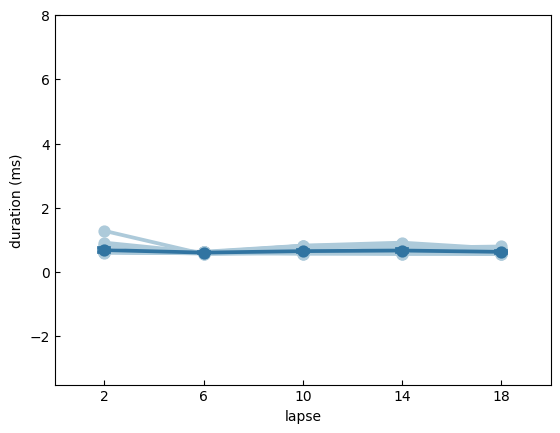

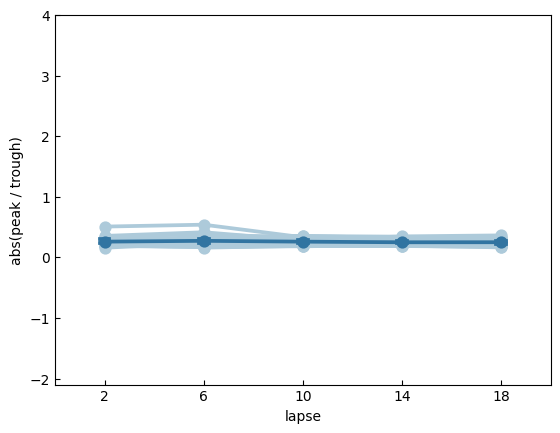

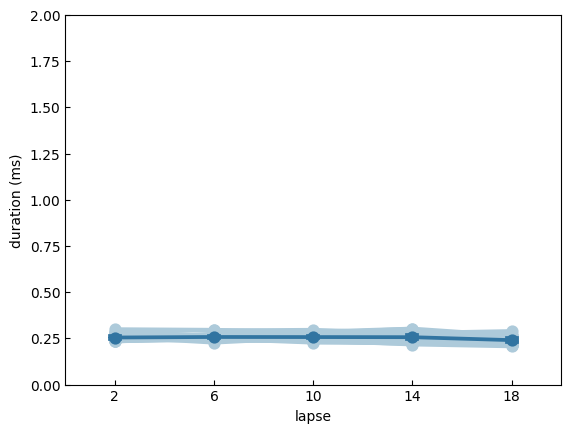

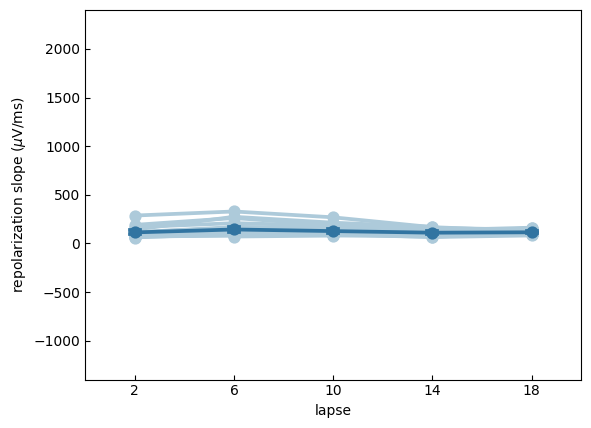

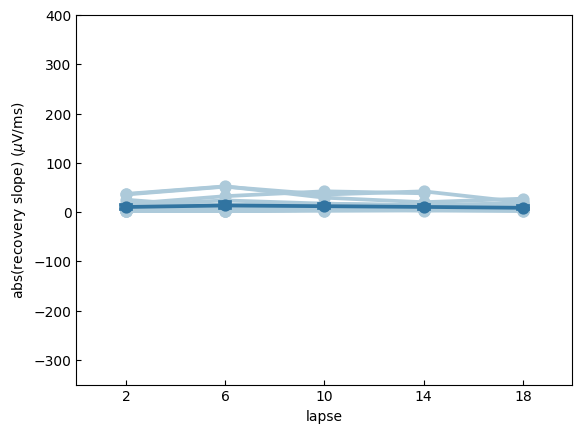

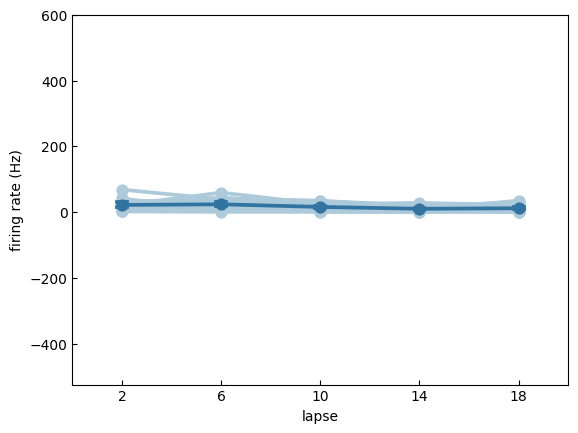

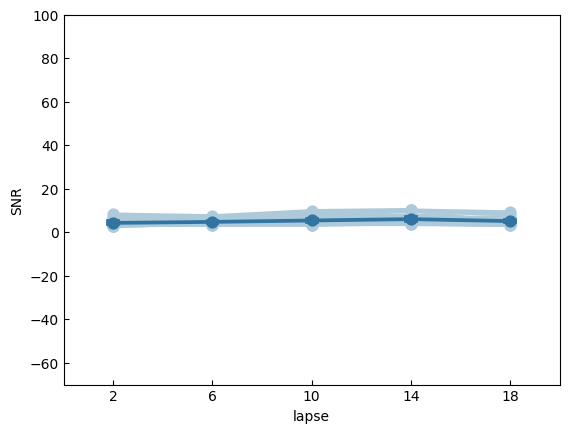

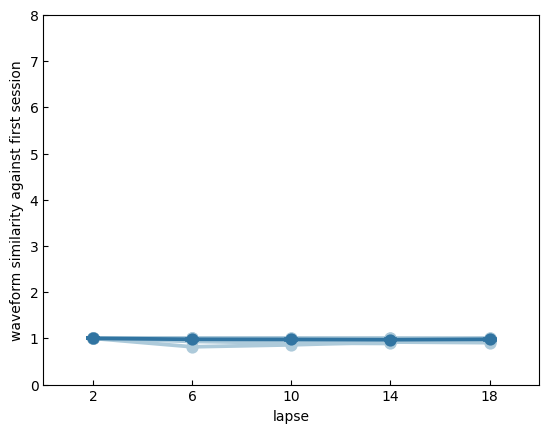

                      Feature  NS_Percentage
0              peak_to_valley          100.0
1           peak_trough_ratio          100.0
2                  half_width          100.0
3        repolarization_slope          100.0
4              recovery_slope          100.0
5                 firing_rate          100.0
6          signal_noise_ratio          100.0
7  waveform_cosine_similarity          100.0


In [1]:
# Extended_Data_Figure5 a-i
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the CSV file
csv_filename = '../Source data/Extended Data Figure 5/template_metrics.csv'
template_metrics = pd.read_csv(csv_filename)

# Define y-axis labels
ylabels = {
    'peak_to_valley': 'duration (ms)', 
    'peak_trough_ratio': 'abs(peak / trough)', 
    'half_width': 'duration (ms)', 
    'repolarization_slope': r'repolarization slope ($\mu$V/ms)', 
    'recovery_slope': r'abs(recovery slope) ($\mu$V/ms)', 
    'firing_rate': 'firing rate (Hz)',
    'signal_noise_ratio': 'SNR',
    'waveform_cosine_similarity': 'waveform similarity against first session'
}

# Original y-limits
original_ylims = {
    'peak_to_valley': (-0.5, 2), 
    'peak_trough_ratio': (-0.3, 1), 
    'half_width': (0, 0.5), 
    'repolarization_slope': (-200, 600), 
    'recovery_slope': (-50, 100), 
    'firing_rate': (-75, 150),
    'signal_noise_ratio': (-10, 25),
    'waveform_cosine_similarity': (0, 2),
}

# Expand y-axis limits by 7x (lower bound) and 4x (upper bound)
ylims = {key: (7 * lower, 4 * upper) for key, (lower, upper) in original_ylims.items()}

figure_folder = 'Extended_Data_Figure5'  # Path to save plots
os.makedirs(figure_folder, exist_ok=True)

# Reproduce the plots
for feature in ylabels.keys():
    plt.figure()
    ax = plt.gca()
    
    # Plot individual unit features
    for shank_unit_id in template_metrics['shank_unit_id'].unique():
        unit_features = template_metrics[template_metrics['shank_unit_id'] == shank_unit_id]
        sns.pointplot(data=unit_features, x='lapse', y=feature, color='#adcada', ax=ax)

    # Plot aggregated trend
    sns.pointplot(data=template_metrics, x='lapse', y=feature, color='#3174a1', capsize=0.1, ax=ax)

    # Set tick direction inward
    ax.tick_params(axis='both', direction='in')

    # Set expanded axis limits and labels
    plt.ylim(*ylims[feature])
    plt.ylabel(ylabels[feature])

    # Save the figure
    plt.savefig(f'{figure_folder}/{feature}.pdf')
    plt.show()
    plt.close()

    import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Set significance level p < 0.05
alpha = 0.05
results = []

# Iterate over all features
for feature in ylabels.keys():
    ns_units = 0
    total_units = len(template_metrics['shank_unit_id'].unique())

    # Iterate over each unit
    for shank_unit_id in template_metrics['shank_unit_id'].unique():
        unit_data = template_metrics[template_metrics['shank_unit_id'] == shank_unit_id]
        lapse_groups = unit_data.groupby('lapse')[feature].apply(list)

        # Perform t-tests
        lapses = lapse_groups.keys()
        n_s_flag = True  # Assume the current unit has all comparisons as non-significant
        for i, lapse1 in enumerate(lapses):
            for lapse2 in list(lapses)[i + 1:]:
                data1 = lapse_groups[lapse1]
                data2 = lapse_groups[lapse2]
                if len(data1) > 1 and len(data2) > 1:  # Ensure sufficient sample size
                    _, p_value = ttest_ind(data1, data2, equal_var=False)
                    if p_value <= alpha:
                        n_s_flag = False
                        break
            if not n_s_flag:
                break

        if n_s_flag:
            ns_units += 1

    # Calculate the percentage of non-significant units
    ns_percentage = (ns_units / total_units) * 100
    results.append({'Feature': feature, 'NS_Percentage': ns_percentage})

# Convert to DataFrame and display
ns_results = pd.DataFrame(results)
print(ns_results)

# Extended_Data_Figure5 j

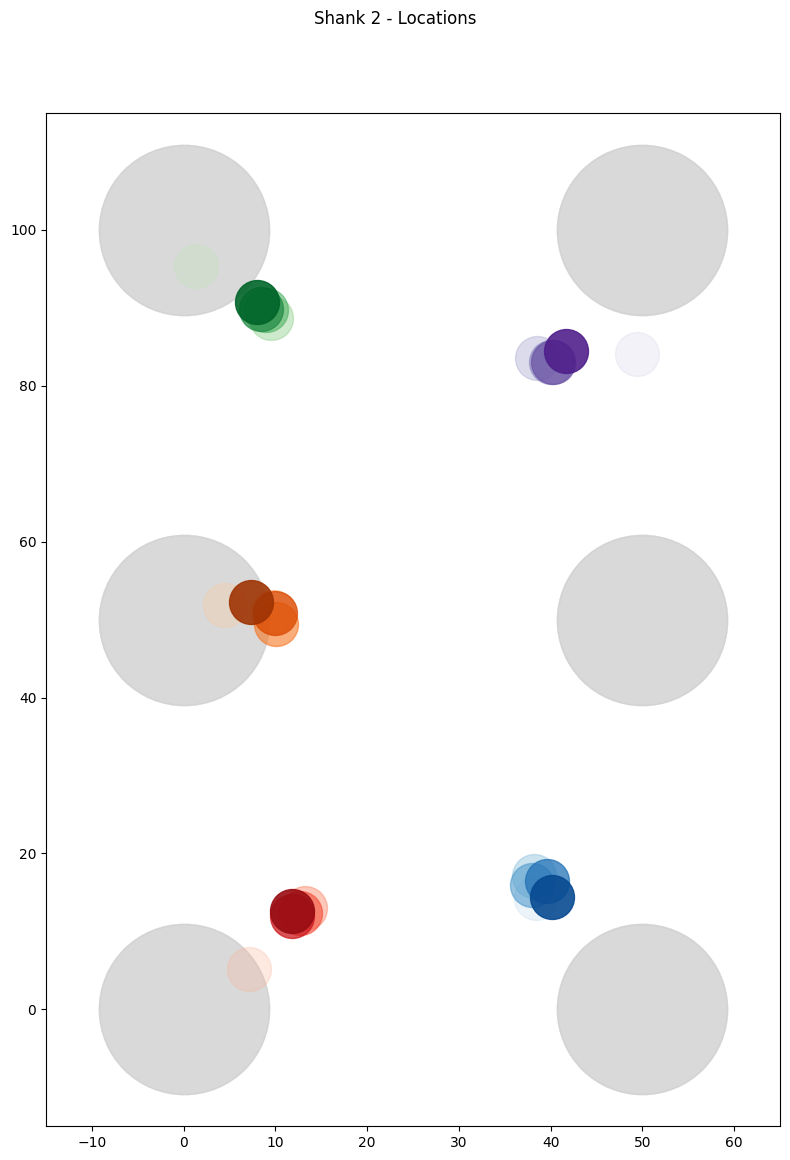

In [2]:
# redraw unit location
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

figure_folder = 'Extended_Data_Figure5'  # Path to save plots

# Load NPZ file
source_data_dir = "../Source data/Extended Data Figure 5" 
npz_path = os.path.join(source_data_dir, "unit_locations.npz")
npz_file = np.load(npz_path, allow_pickle=True)

# Extract stored unit locations while ensuring 1D arrays
valid_keys = [key for key in npz_file.files if key not in ["unit_colors", "segment_lapses"] and not key.startswith("probe_locations")]
data_dict = {key: npz_file[key].reshape(-1) for key in valid_keys}  # Flatten to 1D
locations = pd.DataFrame(data_dict)

# Load stored colors, segment lapses, and electrode locations
unit_colors = npz_file["unit_colors"].item()  # Convert back to dictionary
segment_lapses = npz_file["segment_lapses"].item()
probe_keys = [key for key in npz_file.files if key.startswith("probe_locations")]
probe_locations_dict = {key: npz_file[key] for key in probe_keys}


# **Only Plot Shank 2**
shank = 2
shank_data = locations[locations["shank"] == shank]

fig, ax = plt.subplots(figsize=(8, 11))

# Load and plot probe locations (electrode positions)
probe_keys = [key for key in probe_locations_dict if key.startswith(f"probe_locations_{int(shank)}")]
for probe_key in probe_keys:
    probe_locations = probe_locations_dict[probe_key]
    ax.scatter(probe_locations[:, 0], probe_locations[:, 1], s=15000, color='lightgray', alpha=0.3)

# Find max lapse value for normalization
max_lapse = max(segment_lapses.values()) if segment_lapses else 1

# Plot each unit segment separately with correct transparency
for _, row in shank_data.iterrows():
    unit_key = f"{int(row['shank'])}_{int(row['unit_id'])}_{int(row['segment'])}"

    if unit_key in unit_colors and unit_key in segment_lapses:
        base_color = np.array(unit_colors[unit_key])  # Extract stored RGBA color
        
        # **Apply correct transparency based on segment lapse**
        alpha = min(max(0.2 + 0.7 * row["lapse"] / max_lapse, 0), 1)
        base_color[-1] = alpha  # Modify alpha in stored RGBA color

        ax.scatter(row["x"], row["y"], color=base_color, s=1000)

ax.set_xlim(-15, 65)
ax.set_ylim(-15, 115)
fig.suptitle(f'Shank {shank} - Locations', y=1.05)
plt.tight_layout()

plt.savefig(f"{figure_folder}/redrawn_shank{shank}.pdf")
plt.show()
plt.close()

# Extended_Data_Figure5 k

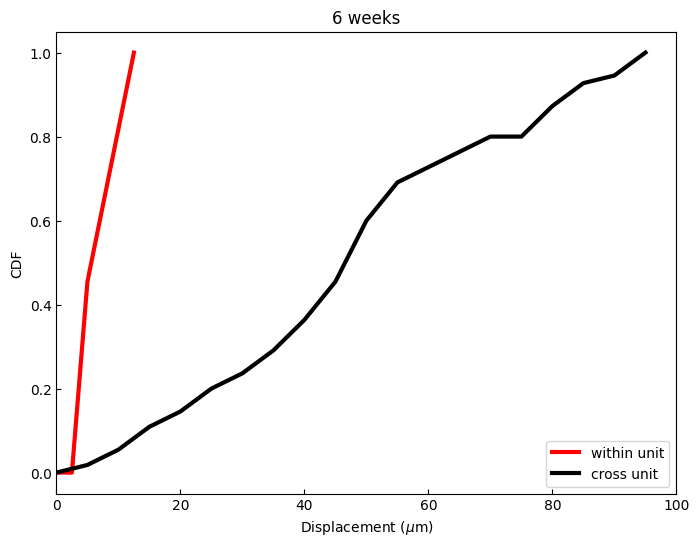

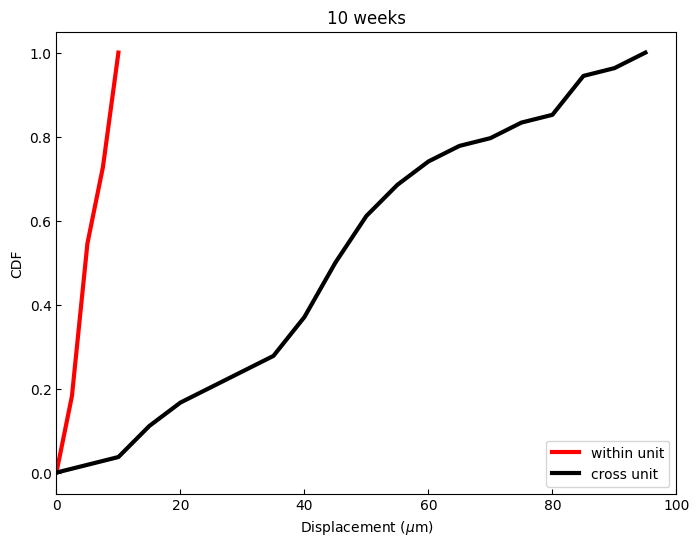

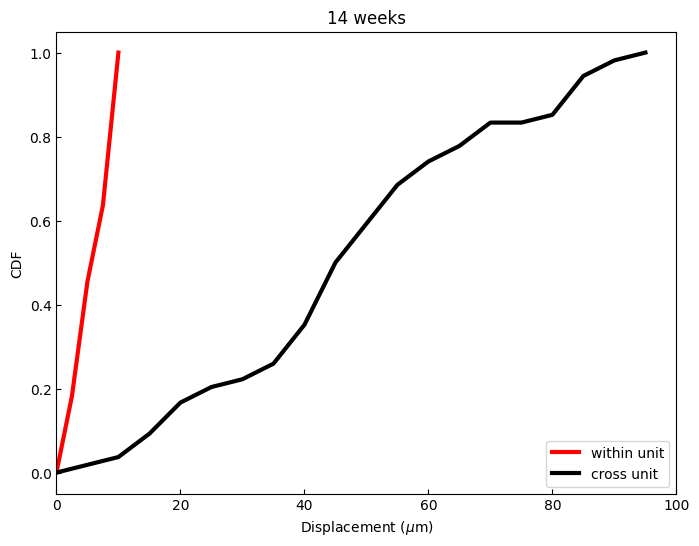

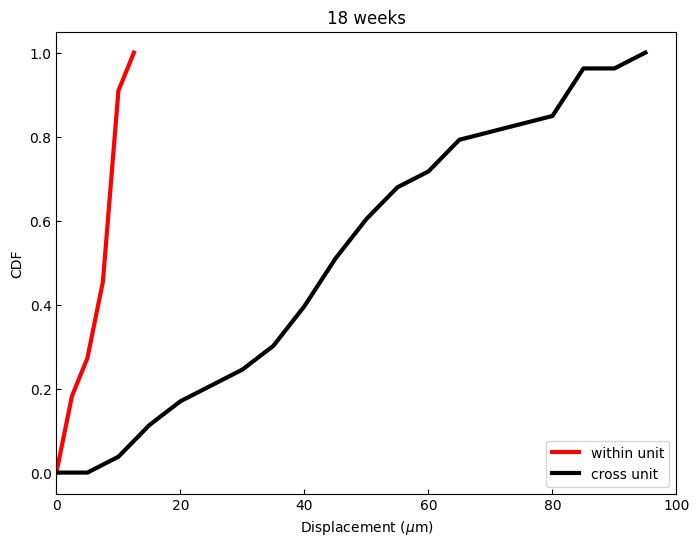

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

figure_folder = 'Extended_Data_Figure5' 

# === Load NPZ Data ===
source_data_dir = "../Source data/Extended Data Figure 5" 
npz_path = os.path.join(source_data_dir, "unit_locations.npz")
npz_file = np.load(npz_path, allow_pickle=True)

# Extract stored unit locations while ensuring 1D arrays
valid_keys = [key for key in npz_file.files if key not in ["unit_colors", "segment_lapses"] and not key.startswith("probe_locations")]
data_dict = {key: npz_file[key].reshape(-1) for key in valid_keys}  # Flatten arrays to 1D
locations = pd.DataFrame(data_dict)

# Load segment lapse values
segment_lapses = npz_file["segment_lapses"].item()

# Get unique lapse values
lapses_plotted = sorted(set(locations["lapse"]))


# === Compute Displacement Drift ===
def compute_drift(within_unit, counted_pairs=None):
    def closure(row):
        if within_unit:
            origin = locations[(locations['shank'] == row['shank']) & 
                               (locations['unit_id'] == row['unit_id']) & 
                               (locations['lapse'] == lapses_plotted[0])]
            if not origin.empty:
                return np.sqrt((row['x'] - origin['x'].values[0])**2 + (row['y'] - origin['y'].values[0])**2)
            return np.nan  # Return NaN if no matching origin is found
        
        else:
            origin = locations[(locations['lapse'] == lapses_plotted[0]) & 
                               ~((locations['shank'] == row['shank']) & 
                                 (locations['unit_id'] == row['unit_id']))]

            source_indices = []
            for source_index, source in origin.iterrows():
                pair = (source['shank'], source['unit_id'], row['shank'], row['unit_id'])
                pair_r = (row['shank'], row['unit_id'], source['shank'], source['unit_id'])
                if pair not in counted_pairs:
                    counted_pairs.add(pair)
                    counted_pairs.add(pair_r)
                    source_indices.append(source_index)

            origin = origin.loc[source_indices]
            if not origin.empty:
                return np.sqrt((row['x'] - origin['x'])**2 + (row['y'] - origin['y'])**2).tolist()
            return []
    
    return closure

# === Function to Plot CDF ===
def plot_cdf(data, bins, label, color):
    count, bins_count = np.histogram(data, bins=bins) 
    pdf = count / sum(count)  # Probability density function
    cdf = np.insert(np.cumsum(pdf), 0, 0)  # Cumulative density function
    index_cutoff = np.where(cdf < 1)[0][-1] + 2  # Cutoff for last value below 1
    plt.plot(bins_count[:index_cutoff], cdf[:index_cutoff], label=label, color=color, linewidth=3) 

# === Generate CDF Plots ===
for lapse in lapses_plotted[1:]:
    plt.figure(figsize=(8, 6))
    lapse_locations = locations[locations['lapse'] == lapse]

    # Compute within-unit drift
    within_units = lapse_locations.apply(compute_drift(within_unit=True), axis=1).dropna()
    plot_cdf(within_units, np.arange(0, 15, 2.5), label='within unit', color='red')

    # Compute cross-unit drift
    counted_pairs = set()
    cross_units = [drift for unit_drifts in lapse_locations.apply(compute_drift(within_unit=False, counted_pairs=counted_pairs), axis=1) for drift in unit_drifts]
    plot_cdf(cross_units, np.arange(0, 100, 5), label='cross unit', color='black')

    # Format plot
    plt.xlim(0, 100)
    plt.legend()
    plt.xlabel(r'Displacement ($\mu$m)')
    plt.ylabel('CDF')
    plt.tick_params(direction='in')
    plt.title(f'{lapse} weeks')

    # Save and show plot
    plot_filename = f"{figure_folder}/displacement_cdf_{lapse}.pdf"
    plt.savefig(plot_filename)
    plt.show()
    plt.close()

# Extended_Data_Figure5 l

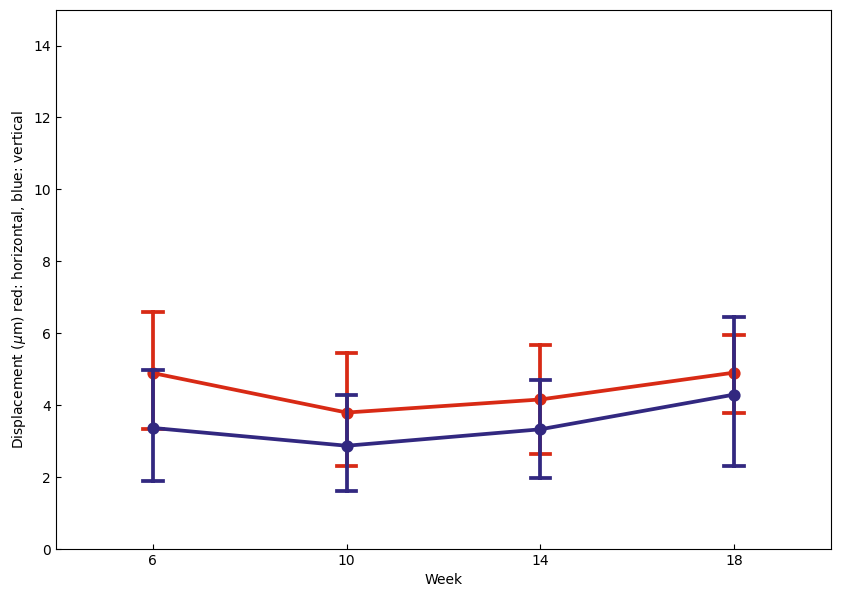

In [5]:
# Initial version deprecated

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

figure_folder = 'Extended_Data_Figure5' 

# Load NPZ file
source_data_dir = "../Source data/Extended Data Figure 5" 
npz_path = os.path.join(source_data_dir, "unit_locations.npz")
npz_file = np.load(npz_path, allow_pickle=True)

# Extract stored unit locations while ensuring 1D arrays
valid_keys = [key for key in npz_file.files if key not in ["unit_colors", "segment_lapses"] and not key.startswith("probe_locations")]
data_dict = {key: npz_file[key].reshape(-1) for key in valid_keys}  # Flatten to 1D
locations = pd.DataFrame(data_dict)

# Load stored segment lapse values
segment_lapses = npz_file["segment_lapses"].item()

# **Prepare data for displacement plot**
lapses_plotted = sorted(set(locations["lapse"]))  # Get unique lapse values
plotted_locations = locations[locations['lapse'] != lapses_plotted[0]]  # Exclude first lapse

# **Plot displacement (horizontal: red, vertical: blue)**
plt.figure(figsize=(10, 7))
ax = plt.gca()

sns.pointplot(data=plotted_locations, x='lapse', y='abs_drift_x', color='#d82a15', ax=ax, capsize=0.1)
sns.pointplot(data=plotted_locations, x='lapse', y='abs_drift_y', color='#322880', ax=ax, capsize=0.1)

plt.tick_params(direction='in')
plt.ylim(0, 15)
plt.xlabel('Week')
plt.ylabel(r'Displacement ($\mu$m) red: horizontal, blue: vertical')

# **Save and show plot**
plot_filename = f"{figure_folder}/displacement_plot.pdf"
plt.savefig(plot_filename)
plt.show()
plt.close()

